In [1]:
import math
from multiprocessing import Pool
import os
import sys
import itertools
import time
import tempfile
import pickle

sys.path.append(os.path.abspath(os.pardir))

%matplotlib inline

import keras
import numpy as np
import pandas as pd
import seaborn as sns

# Metrics
from sklearn.metrics import f1_score

# Notebook helper methods
from tdparse import notebook_helper
# Models
from tdparse.models.tdlstm import LSTM, TDLSTM, TCLSTM
# Tokenisers
from tdparse.tokenisers import whitespace, ark_twokenize, stanford
# Word Vectors
from tdparse.word_vectors import PreTrained, GloveTwitterVectors, GloveCommonCrawl
# Get the data
from tdparse.helper import read_config, full_path
from tdparse.parsers import dong, semeval_14

Using TensorFlow backend.


In [2]:
# Load the datasets
dong_train = dong(full_path(read_config('dong_twit_train_data')))
dong_test = dong(full_path(read_config('dong_twit_test_data')))
# Load the word vectors
sswe_path = full_path(read_config('sswe_files')['vo_zhang'])
sswe = PreTrained(sswe_path, name='sswe', padding_value=0)
glove_50 = GloveTwitterVectors(50, padding_value=0)
glove_100 = GloveTwitterVectors(100, padding_value=0)
glove_200 = GloveTwitterVectors(200)
word_vectors = [sswe, glove_50, glove_100, glove_200]

# Testing LSTM for the effect of validation set variation

In this notebook we show the effect of change in train and validation set with respect to training the 3 LSTM based models that [Tang et al.](https://www.aclweb.org/anthology/C16-1311) presented in his paper and show how close our implementation of his models come compared to the results stated in their paper. The models that they created are the following:

1. **LSTM** - Standard single layered LSTM where the hidden layer output is equal to the size of the input vector dimensions e.g. if the words vectors are 50 dimensions in size then the LSTM hidden state and output is 50 dimensions.
2. **TDLSTM** - Target Dependent LSTM. This consists of 2 LSTMs either side of the target word that the sentiment is with respect to. The Left LSTM reads words in from left to right and goes up to the last word in the target word. The right LSTM reads words right to left and goes up to the last word in the target word as well. Again the LSTM hidden state and output is the same as the dimension of the input.
3. **TCLSTM** - Target Context LSTM is the same as the TDLSTM but the input instead of being just the word vectors it reads in and word vectors are concatenated with the vector representation of the target word. If the target word is multiple words then it is the average of those word vectors.

The names of these models are direct matches to the class names that represent these models in our code base.

In [Tang et al.](https://www.aclweb.org/anthology/C16-1311) paper they never state the number of Epochs that they train for and their code base is no longer avaliable therefore instead of guessing the number we decided to use Early Stopping to find the optimal number of Epochs to train for.

However using Early Stopping comes with other drawbacks. As the dataset that they used for this paper (and all of the other datasets we look at) does not contain a validation set we have to create a train and validation set from the original training data. **We show in this notebook the effect of randomly splitting the training dataset into train and validation sets on the models result and how close we can reproduce the results of Tang et al.**

**NOTE** The splitting is not quiet random we use Strattified splitting therefore keeping the dataset representative with respect to the labels.


### Dataset used

The dataset we use is the same as [Tang et al.](https://www.aclweb.org/anthology/C16-1311) used in their paper which is [Dong et al]() Twitter dataset which is a general domain dataset.

### Word vectors used

We use the same word vectors as those shown in the paper apart from the SSWE-h and SSWE-r which we could not find the *SSWE-u* is the equivalent to *SSWE* in our code base. We got the *SSWE* word vectors from the following [code base](https://github.com/bluemonk482/tdparse) and the Gove Twitter vectors from [here](https://nlp.stanford.edu/projects/glove/)

### The experiment

Below we run each of the 3 models 30 times with different random strattified splitting and then repeat this for each word vector. **THIS TAKES A LONG TIME** therefore we have saved all of the result and if you would like to repeat the experiments set *re_write* to True

**Last Note on configurations** The pad size parameter that has to be set for each model this states how many words our LSTM model takes into accout. Setting it to -1 means that we use the length of the largest sentence (tweet) in the training set which is what was stated in the paper.

In [3]:
result_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'results', 'TDLstm'))
lstm_result_folder = os.path.join(result_folder, 'lstm')
os.makedirs(lstm_result_folder, exist_ok=True)
repeated_params = {'reproducible' : False, 'validation_size' : 0.3, 
                   'patience' : 10, 'epochs' : 300, 'verbose' : 0, 
                   'org_initialisers' : True}
score_kwargs = {'average' : 'macro'}
pad_size = -1
for word_vector in word_vectors:
    lstm_repeated_results = os.path.join(lstm_result_folder, 'LSTM {} Repeated Results.json'.format(word_vector))
    lstm = LSTM(ark_twokenize, word_vector, lower=True, pad_size=pad_size)
    lstm_rep_results = lstm.repeated_results(dong_train, dong_test, 30, f1_score,
                                             'Dong Twitter', results_file=lstm_repeated_results,
                                             re_write=False, score_kwargs=score_kwargs, **repeated_params)

In [4]:
result_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'results', 'TDLstm'))
tdlstm_result_folder = os.path.join(result_folder, 'tdlstm')
os.makedirs(tdlstm_result_folder, exist_ok=True)
repeated_params = {'reproducible' : False, 'validation_size' : 0.3, 
                   'patience' : 10, 'epochs' : 300, 'verbose' : 0, 
                   'org_initialisers' : True}
score_kwargs = {'average' : 'macro'}
pad_size = -1
for word_vector in word_vectors:
    tdlstm_repeated_results = os.path.join(tdlstm_result_folder, 'TDLSTM {} Pad Size {} Repeated Results.json'\
                                                                 .format(word_vector, pad_size))
    tdlstm = TDLSTM(ark_twokenize, word_vector, lower=True, pad_size=pad_size)
    tdlstm_rep_results = tdlstm.repeated_results(dong_train, dong_test, 30, f1_score,
                                                 'Dong Twitter', results_file=tdlstm_repeated_results,
                                                 re_write=False, score_kwargs=score_kwargs, **repeated_params)

In [5]:
result_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'results', 'TDLstm'))
tclstm_result_folder = os.path.join(result_folder, 'tclstm')
os.makedirs(tclstm_result_folder, exist_ok=True)
repeated_params = {'reproducible' : False, 'validation_size' : 0.3, 
                   'patience' : 10, 'epochs' : 300, 'verbose' : 0, 
                   'org_initialisers' : True}
score_kwargs = {'average' : 'macro'}
pad_size = -1
for word_vector in word_vectors:
    tclstm_repeated_results = os.path.join(tclstm_result_folder, 'TCLSTM {} Pad Size {} Repeated Results.json'\
                                                                 .format(word_vector, pad_size))
    tclstm = TCLSTM(ark_twokenize, word_vector, lower=True, pad_size=pad_size)
    tclstm_rep_results = tclstm.repeated_results(dong_train, dong_test, 1, f1_score,
                                                 'Dong Twitter', results_file=tclstm_repeated_results,
                                                 re_write=False, score_kwargs=score_kwargs, **repeated_params)

Now we have all of the data saved in the respective result files we shall analysis it to see how much the results vary and how close we get to the result stated in Tang et al. paper

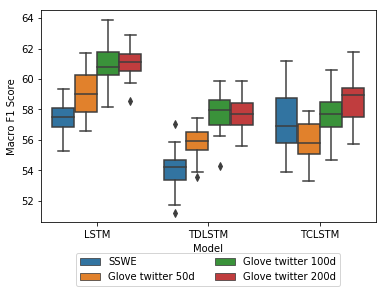

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns

model_folder = {'lstm' : lstm_result_folder, 'tdlstm' : tdlstm_result_folder,
                'tclstm' : tclstm_result_folder}
model_word_vector_results = pd.DataFrame()

# Original results inputted first and then add the result we found
mean_glove_200_results = {'LSTM' : [64.7], 'TDLSTM' : [69.0], 'TCLSTM' : [69.5]}

word_vector_type = []
word_vector_results = []
model_result = []
word_vector_names = ['{}'.format(word_vector) for word_vector in word_vectors]
for model, folder in model_folder.items():
    
    for word_vector_name in word_vector_names:
        result_file = '{} {} Pad Size {} Repeated Results.json'.format(model, word_vector_name, pad_size)
        if model == 'lstm':
            result_file = '{} {} Repeated Results.json'.format(model, word_vector_name)
        result_file = os.path.join(folder, result_file)
        results = notebook_helper.get_json_data(result_file, 'Dong Twitter')
        num_results = len(results)
        word_vector_results.extend(results)
        
        if word_vector_name == 'glove twitter 200d':
            mean_glove_200_results[model.upper()].append(np.array(results).mean() * 100)
        
        if word_vector_name == 'sswe':
            word_vector_name = 'SSWE'
            word_vector_type.extend([word_vector_name] * num_results)
        else:
            word_vector_type.extend([word_vector_name.capitalize()] * num_results)
        model_result.extend([model.upper()] * num_results)

model_word_vector_results['Macro F1 Score'] = np.array(word_vector_results) * 100
model_word_vector_results['Model'] =  model_result
model_word_vector_results['Word Vector'] = word_vector_type

#model_word_vector_results.columns = columns
model_word_vector_results
ax = sns.boxplot(x="Model", y="Macro F1 Score", hue="Word Vector", 
                 data=model_word_vector_results)
ax.figure.set_size_inches(6,3.9)
leg = ax.legend(loc=9, bbox_to_anchor=(0.5, -0.12), ncol=2)
ax.figure.savefig('TDLSTM dist results.png', bbox_extra_artists=(leg,), bbox_inches='tight', dpi=150)


As we can see above the results vary by quiet a lot but interestingly the LSTM method performed the best which is a different result to the original paper which states that the LSTM method performs worse than all of the other models. 

Generally the TCLSTM seems to perform better than TDLSTM but does vary a lot more therefore making it more unpredictable.

Also apart from the TCLSTM model where the 100 dimension Glove vector performs worse than the SSWE word vector the order of the performance of the word vectors is the same as the original paper.

However as we can see all of the model tend to vary a lot and are therefore quiet suseptiable to change in training and validation splitting. Thus showing without specify Train and Validation split it is very difficult to reproduce the results of an experiment. However as you can see we never reach the values reported in the original paper thus leaving us in the dark on how they produced those results.


Below we show the mean values of the repeated experiments above and state these as our reported results and compared them to the original results from Tang et al paper.

In [28]:
pd.DataFrame(mean_glove_200_results, index=['Original', 'Reproduced']).round(1)

,LSTM,TCLSTM,TDLSTM
Original,64.7,69.5,69.0
Reproduced,61.1,58.6,57.7
